# Voxel CSV --> Neural Cellular Automata

In [1]:
from tqdm.notebook import tqdm
import wandb
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from moviepy import ImageSequenceClip

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Voxel CSV to Torch Tensor

KeyboardInterrupt: 

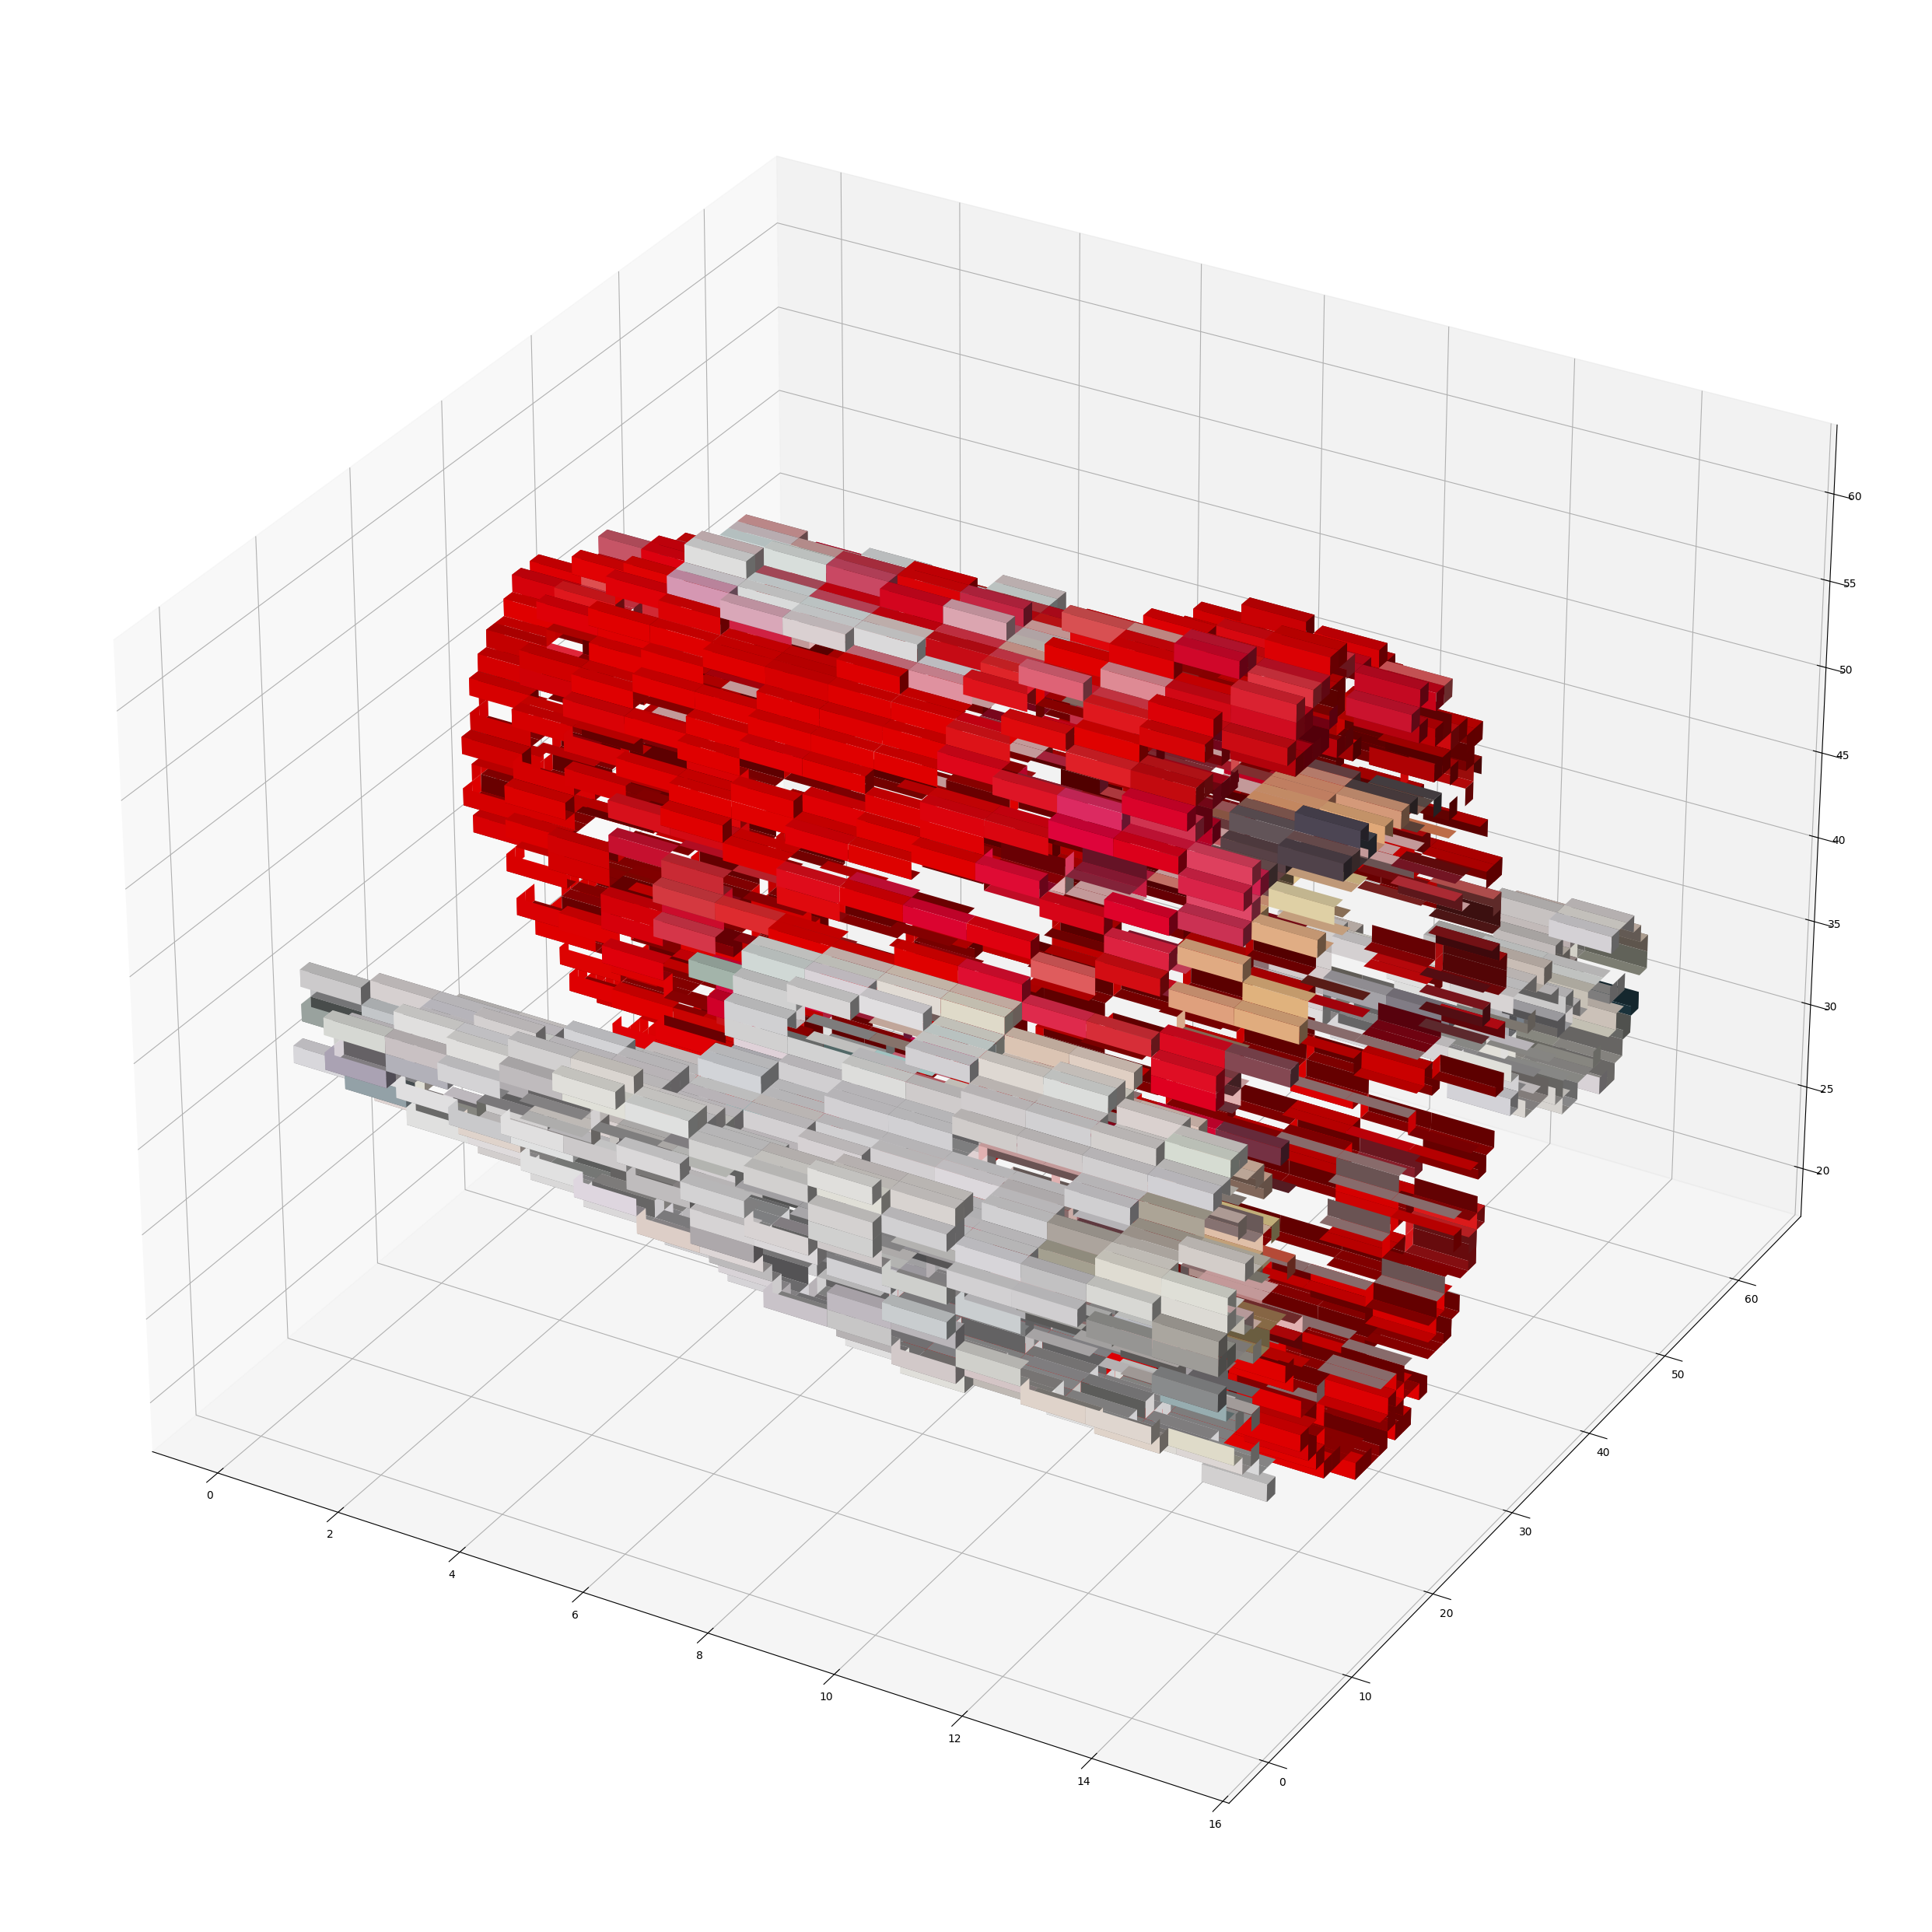

In [ ]:
### FULL-RES VERSION (Use this if you want full-res)
###    => Only run either this cell or the next cell

img_data_path = "../../data/mario_vox.npy"

environment_size = 64
alive_thres = 0.1
vox_data = np.load(img_data_path)
in_vox_shape = vox_data[:, :3].max(axis=0) - vox_data[:, :3].min(axis=0) + 1  # find bounding box based on input data
left_padding = (environment_size - in_vox_shape) // 2

# vox_data = np.array(pd.read_csv(img_data_path, header=None))
rgba_vox = np.zeros((environment_size, environment_size, environment_size, 4))

for voxel in vox_data:
    pos = (voxel[:3] + left_padding).astype(int)
    if np.all((0 <= pos) & (pos < environment_size)):
        pos = tuple(pos)
        color = np.concatenate(((voxel[3:] / 255), np.ones(1)))
        rgba_vox[pos] = color

fig = plt.figure(figsize=(32, 32))
ax = fig.add_subplot(projection='3d')
ax.voxels(rgba_vox[..., 3] > alive_thres, facecolors=rgba_vox[..., :3])
plt.show()

rgba_voxels = torch.tensor(rgba_vox, dtype=torch.float32).permute(3, 0, 1, 2).to(device)


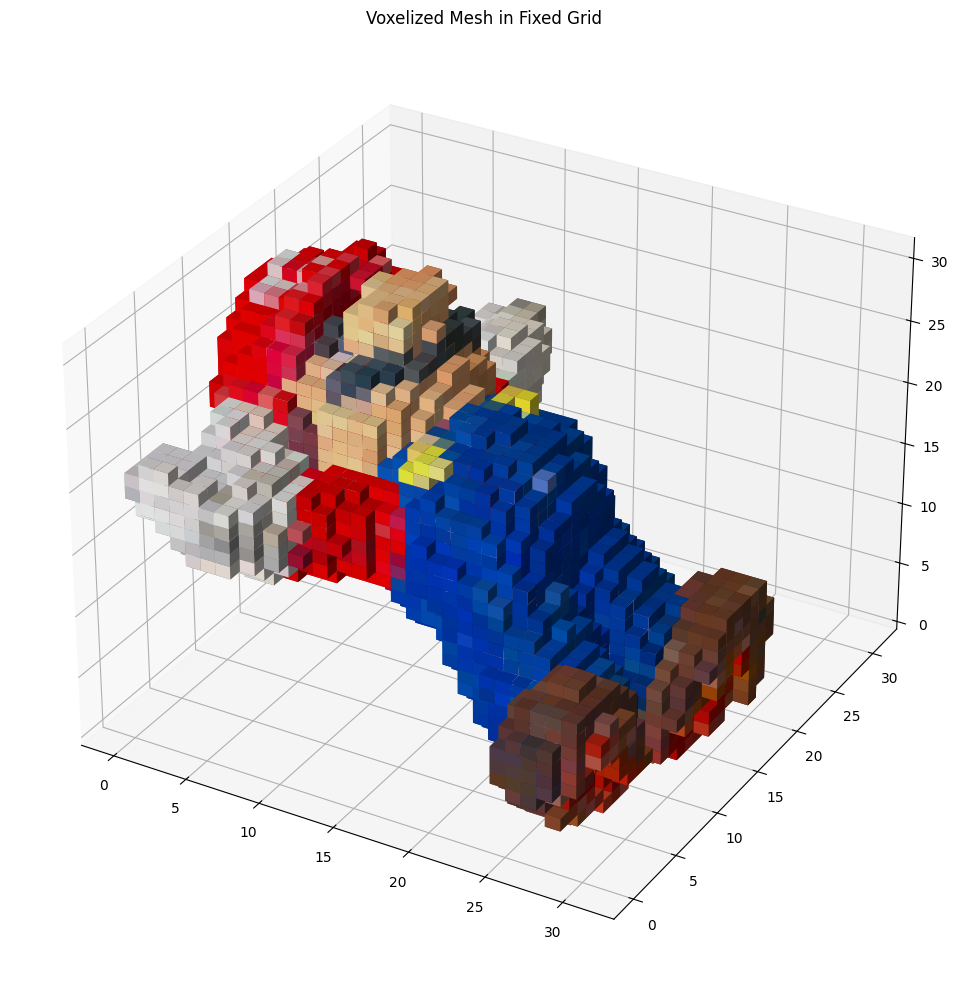

In [ ]:
### NORMALIZED VERSION (PREFERRED)
###    => Only run either this cell or the cell before

###   - Trying to downsample large meshes into small environments
img_data_path = "../../data/mario_vox.npy"

environment_size = 32
alive_thres = 0.1

vox_data = np.load(img_data_path)
coords = vox_data[:, :3]
min_coords = coords.min(axis=0)
max_coords = coords.max(axis=0)

# Normalize to [0, 1], then scale to [0, environment_size-1]
scaled_coords = (coords - min_coords) / (max_coords - min_coords + 1e-8)
voxel_coords = (scaled_coords * (environment_size - 1)).astype(int)  # shape: (N, 3)

rgba_vox = np.zeros((environment_size, environment_size, environment_size, 4), dtype=np.float32)

for i in range(len(voxel_coords)):
    x, y, z = voxel_coords[i]
    r, g, b = vox_data[i, 3:] / 255.0
    rgba_vox[x, y, z] = [r, g, b, 1.0] # 1.0 is for alpha

alive_thres = 0.1
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.voxels(rgba_vox[..., 3] > alive_thres, facecolors=rgba_vox[..., :3])
plt.title("Voxelized Mesh in Fixed Grid")
plt.tight_layout()
plt.show()

rgba_voxels = torch.tensor(rgba_vox, dtype=torch.float32).permute(3, 0, 1, 2).to(device)

### Model

In [3]:
def generate_seed(n_channels, env_dim):
    seed = torch.zeros((n_channels, env_dim, env_dim, env_dim), dtype=torch.float32)
    seed[3:, env_dim//2, env_dim//2, env_dim//2] = 1.
    return seed

class NCA(nn.Module):
    def __init__(self, n_channels, env_dim, learn_seed=True, seed_std=0.01, update_prob=0.5, alive_thres=0.1, overgrowth_to_undergrowth_penalty=1.0):
        super().__init__()
        self.temperature = 50
        self.update_prob = update_prob
        self.alive_thres = alive_thres
        self.overgrowth_to_undergrowth_penalty = overgrowth_to_undergrowth_penalty

        self.env_dim = env_dim
        self.learn_seed = learn_seed
        self.seed = generate_seed(n_channels, env_dim)
        if learn_seed:
            self.seed_center = nn.Parameter(torch.empty(n_channels-4)).to(device)
            nn.init.kaiming_normal_(self.seed_center.unsqueeze(1), mode='fan_in', nonlinearity='relu')
        self.seed = self.seed.to(device)

        # Perception layer
        self.perceive = nn.Conv3d(n_channels, 3*n_channels, kernel_size=3, padding=1)
        # self.norm1 = nn.LayerNorm((3 * n_channels, env_dim, env_dim, env_dim))
        # self.norm1 = nn.LayerNorm((3 * n_channels-4, env_dim, env_dim, env_dim))
        # self.norm1 = nn.GroupNorm(num_groups=11, num_channels=3*n_channels-4)
        
        # Processing layers with residual connections
        self.process1 = nn.Conv3d(3*n_channels, 2*n_channels, kernel_size=1)
        self.process2 = nn.Conv3d(2*n_channels, n_channels, kernel_size=1)
    
    def get_seed(self):
        if self.learn_seed:
            seed = self.seed.clone()
            seed[4:, self.env_dim//2, self.env_dim//2, self.env_dim//2] = self.seed_center
            return seed
        else:
            return self.seed

    def forward(self, x, alive, use_soft_living_mask=False):
        nbrs = F.max_pool3d(alive, kernel_size=3, stride=1, padding=1)
        update_mask = ((torch.rand(x[:, :1].shape, dtype=torch.float32).to(device) <= self.update_prob) * (nbrs>0)).float()
        
        y = self.perceive(x)
        # y = self.norm1(y) # For LayerNorm
        # hidden_state = y[:, 4:, ...]
        # hidden_norm = self.norm1(hidden_state) 
        # y = torch.cat((y[:, :4, ...], hidden_norm), dim=1)
        y = F.relu(y)
        
        z = self.process1(y)
        z = F.relu(z)
        dx = self.process2(z)
        
        x = x + dx*update_mask
        
        if self.training:
            soft_mask = F.sigmoid((F.max_pool3d(x[:, 3:4], kernel_size=3, stride=1, padding=1) - self.alive_thres) * self.temperature)
            # alpha = 0.8
            # hard_mask = (F.max_pool3d(x[:, 3:4], kernel_size=3, stride=1, padding=1) > self.alive_thres).float()
            # living_mask = alpha * soft_mask + (1-alpha) * hard_mask
            living_mask = soft_mask
        else:
            living_mask = (F.max_pool3d(x[:, 3:4], kernel_size=3, stride=1, padding=1) > self.alive_thres).float()
            
        return x * living_mask, living_mask
    
    def get_loss(self, x, target_vox, prev_x, stability_factor):
        target = torch.tile(target_vox, (x.shape[0], 1, 1, 1, 1))
        x_rgba = x[:, :4]
        prev_x_rgba = prev_x[:, :4]

        x_living_mask = (x_rgba[:, 3:4] > self.alive_thres).float()
        target_living_mask = (target[:, 3:4] > self.alive_thres).float()
        zeros = torch.zeros(target.shape).to(device)

        undergrowth_loss = F.mse_loss(x_rgba * target_living_mask, target * target_living_mask) 
        overgrowth_loss = self.overgrowth_to_undergrowth_penalty * F.mse_loss(x_rgba * (1.-target_living_mask) * x_living_mask, zeros)
        stability_loss = stability_factor * F.mse_loss(x_rgba-prev_x_rgba, zeros)
        loss = undergrowth_loss + overgrowth_loss + stability_loss
        return loss, undergrowth_loss, overgrowth_loss, stability_loss


In [4]:
model_name = "final_mario_curriculum4_noln_damage_4-12_over10"

batch_size = 8
input_channels = 16
learn_seed = True
seed_std = 0.05
update_prob = 0.9 # 0.75
over_to_under_penalty = 10
damage_prob = 0.8

epochs = 25000
min_iter, max_iter = 16, 80
curriculum_eval_updates = np.array([(0, 1), (48, 64), (65, 128), (128, 512), (512, 1024)])
curriculum_selection_probs = np.array([[1., 0, 0, 0, 0],
                                       [1/2, 1/2, 0, 0, 0],
                                       [1/3, 1/3, 1/3, 0, 0], 
                                       [1/3, 1/6, 1/6, 1/3, 0], 
                                       [1/4, 1/8, 1/8, 1/4, 1/4]])

n_curriculums = len(curriculum_eval_updates)
assert epochs % n_curriculums == 0
epoch_per_curriculum = epochs // n_curriculums

learning_rate = 2e-3 #2e-4
weight_decay = 0

model = NCA(input_channels, 
            environment_size, 
            learn_seed=learn_seed, 
            update_prob=update_prob, 
            alive_thres=alive_thres, 
            overgrowth_to_undergrowth_penalty=over_to_under_penalty)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

def init_weights(m):
    if isinstance(m, nn.Conv3d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        m.weight.data *= 0.1
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)



NCA(
  (perceive): Conv3d(16, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (process1): Conv3d(48, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (process2): Conv3d(32, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
)

### Model Training (Skip to Eval if just loading from Checkpoint)

In [5]:
wandb_log = True

if wandb_log:
    project_name = "n3ctar"
    run_name = model_name
    wandb_run = wandb.init(project=project_name, name=run_name)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: g4ce99 (g4ce99-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
losses = []
empty_cache_n_iter = 50 # 25
epoch_ckpt_freq = 1000

# New Way:
curriculum_choices = np.zeros((n_curriculums, epoch_per_curriculum), dtype=int)
for i in range(n_curriculums):
    curriculum_choices[i] = np.random.choice(n_curriculums, size=epoch_per_curriculum, p=curriculum_selection_probs[i])
curriculum_choices = curriculum_choices.flatten()

mins = curriculum_eval_updates[:, 0]
maxs = curriculum_eval_updates[:, 1]

selected_mins = mins[curriculum_choices]
selected_maxs = maxs[curriculum_choices]

eval_update_samples = np.random.randint(low=selected_mins, high=selected_maxs)

for i in tqdm(range(epochs)):
    model.temperature = 5 + 45 * min(i/1000, 1.0)
    seed = model.get_seed()
    x = seed.unsqueeze(0).repeat(batch_size, 1, 1, 1, 1)
    living_mask = (x[:,3:4] > model.alive_thres).float()
    
    n_eval_iter = eval_update_samples[i]
    
    if n_eval_iter > 0:
        model.eval()
        with torch.no_grad():
            for _ in range(n_eval_iter):
                x, living_mask = model(x, living_mask, i<0.05*epochs)

            if np.random.rand() < damage_prob:
                for i in range(np.random.randint(4, 12)):
                    damage_x = np.random.randint(0, 26)
                    damage_y = np.random.randint(0, 26)
                    damage_z = np.random.randint(0, 26)
                    x[:, :, damage_x:damage_x+6, damage_y:damage_y+6, damage_z:damage_z+6] = 0
                    living_mask[:, :, damage_x:damage_x+6, damage_y:damage_y+6, damage_z:damage_z+6] = 0

    model.train()
    n_iter = np.random.randint(min_iter, max_iter)
    prev_x=None
    for _ in range(n_iter):
        prev_x=x
        x, living_mask = model(x, living_mask, i<0.05*epochs)
    loss, underloss, overloss, stabilityloss = model.get_loss(x, rgba_voxels, prev_x, stability_factor=10*i/epochs)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Tighter gradient clipping
    optimizer.step()
    losses.append(loss.item())
    if wandb_log:
        metrics = {
            "Total Loss": loss.item(),
            "Undergrowth Loss": underloss.item(),
            "Overgrowth Loss": overloss.item(),
            "Stability Loss": stabilityloss.item()
        }
        wandb_run.log(metrics, step=i)

    if (i+1) % epoch_ckpt_freq == 0:
        os.makedirs("./ckpts", exist_ok=True)
        torch.save(model.state_dict(), os.path.join(f"./ckpts/{model_name}_{i+1}.pth"))

    if  i % empty_cache_n_iter == empty_cache_n_iter-1:
        if not wandb_log:
            print(f"Epoch: {i}, Loss: {loss.item()}, Undergrowth Loss: {underloss.item()}, Overgrowth Loss: {overloss.item()}")
        torch.cuda.empty_cache()

if wandb_log:
    wandb_run.finish()
else:
    plt.plot(range(len(losses)), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.show()

# os.makedirs("./ckpts", exist_ok=True)
torch.save(model.state_dict(), os.path.join(f"./ckpts/{model_name}.pth"))

  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
torch.save(model.state_dict(), os.path.join(f"./ckpts/{model_name}_{19000}.pth"))

### Model Evaluation

In [5]:
load_from_ckpt = True

if load_from_ckpt:
    model.load_state_dict(torch.load(f"./ckpts/{model_name}.pth"))
    model.to(device)

In [11]:
def voxel_plot(color_voxels, save_fig=False, img_dir=None, iter=None):
    # os.makedirs(img_dir, exist_ok=True)
    if save_fig:
        os.makedirs(os.path.join(img_dir, model_name), exist_ok=True)

    rgba_vox = color_voxels.permute(1, 2, 3, 0).detach().cpu().numpy()
    fig = plt.figure(figsize=(32, 32))
    ax = fig.add_subplot(projection='3d')
    ax.voxels(rgba_vox[..., 3] > alive_thres, facecolors=rgba_vox[..., :3])
    ax.set_xlim(0, environment_size)
    ax.set_ylim(0, environment_size)
    ax.set_zlim(0, environment_size)
    if save_fig:
        plt.savefig(os.path.join(img_dir, model_name, f"voxel_{iter}.png"))
        plt.close()
    else:
        plt.show()

  0%|          | 0/32 [00:00<?, ?it/s]

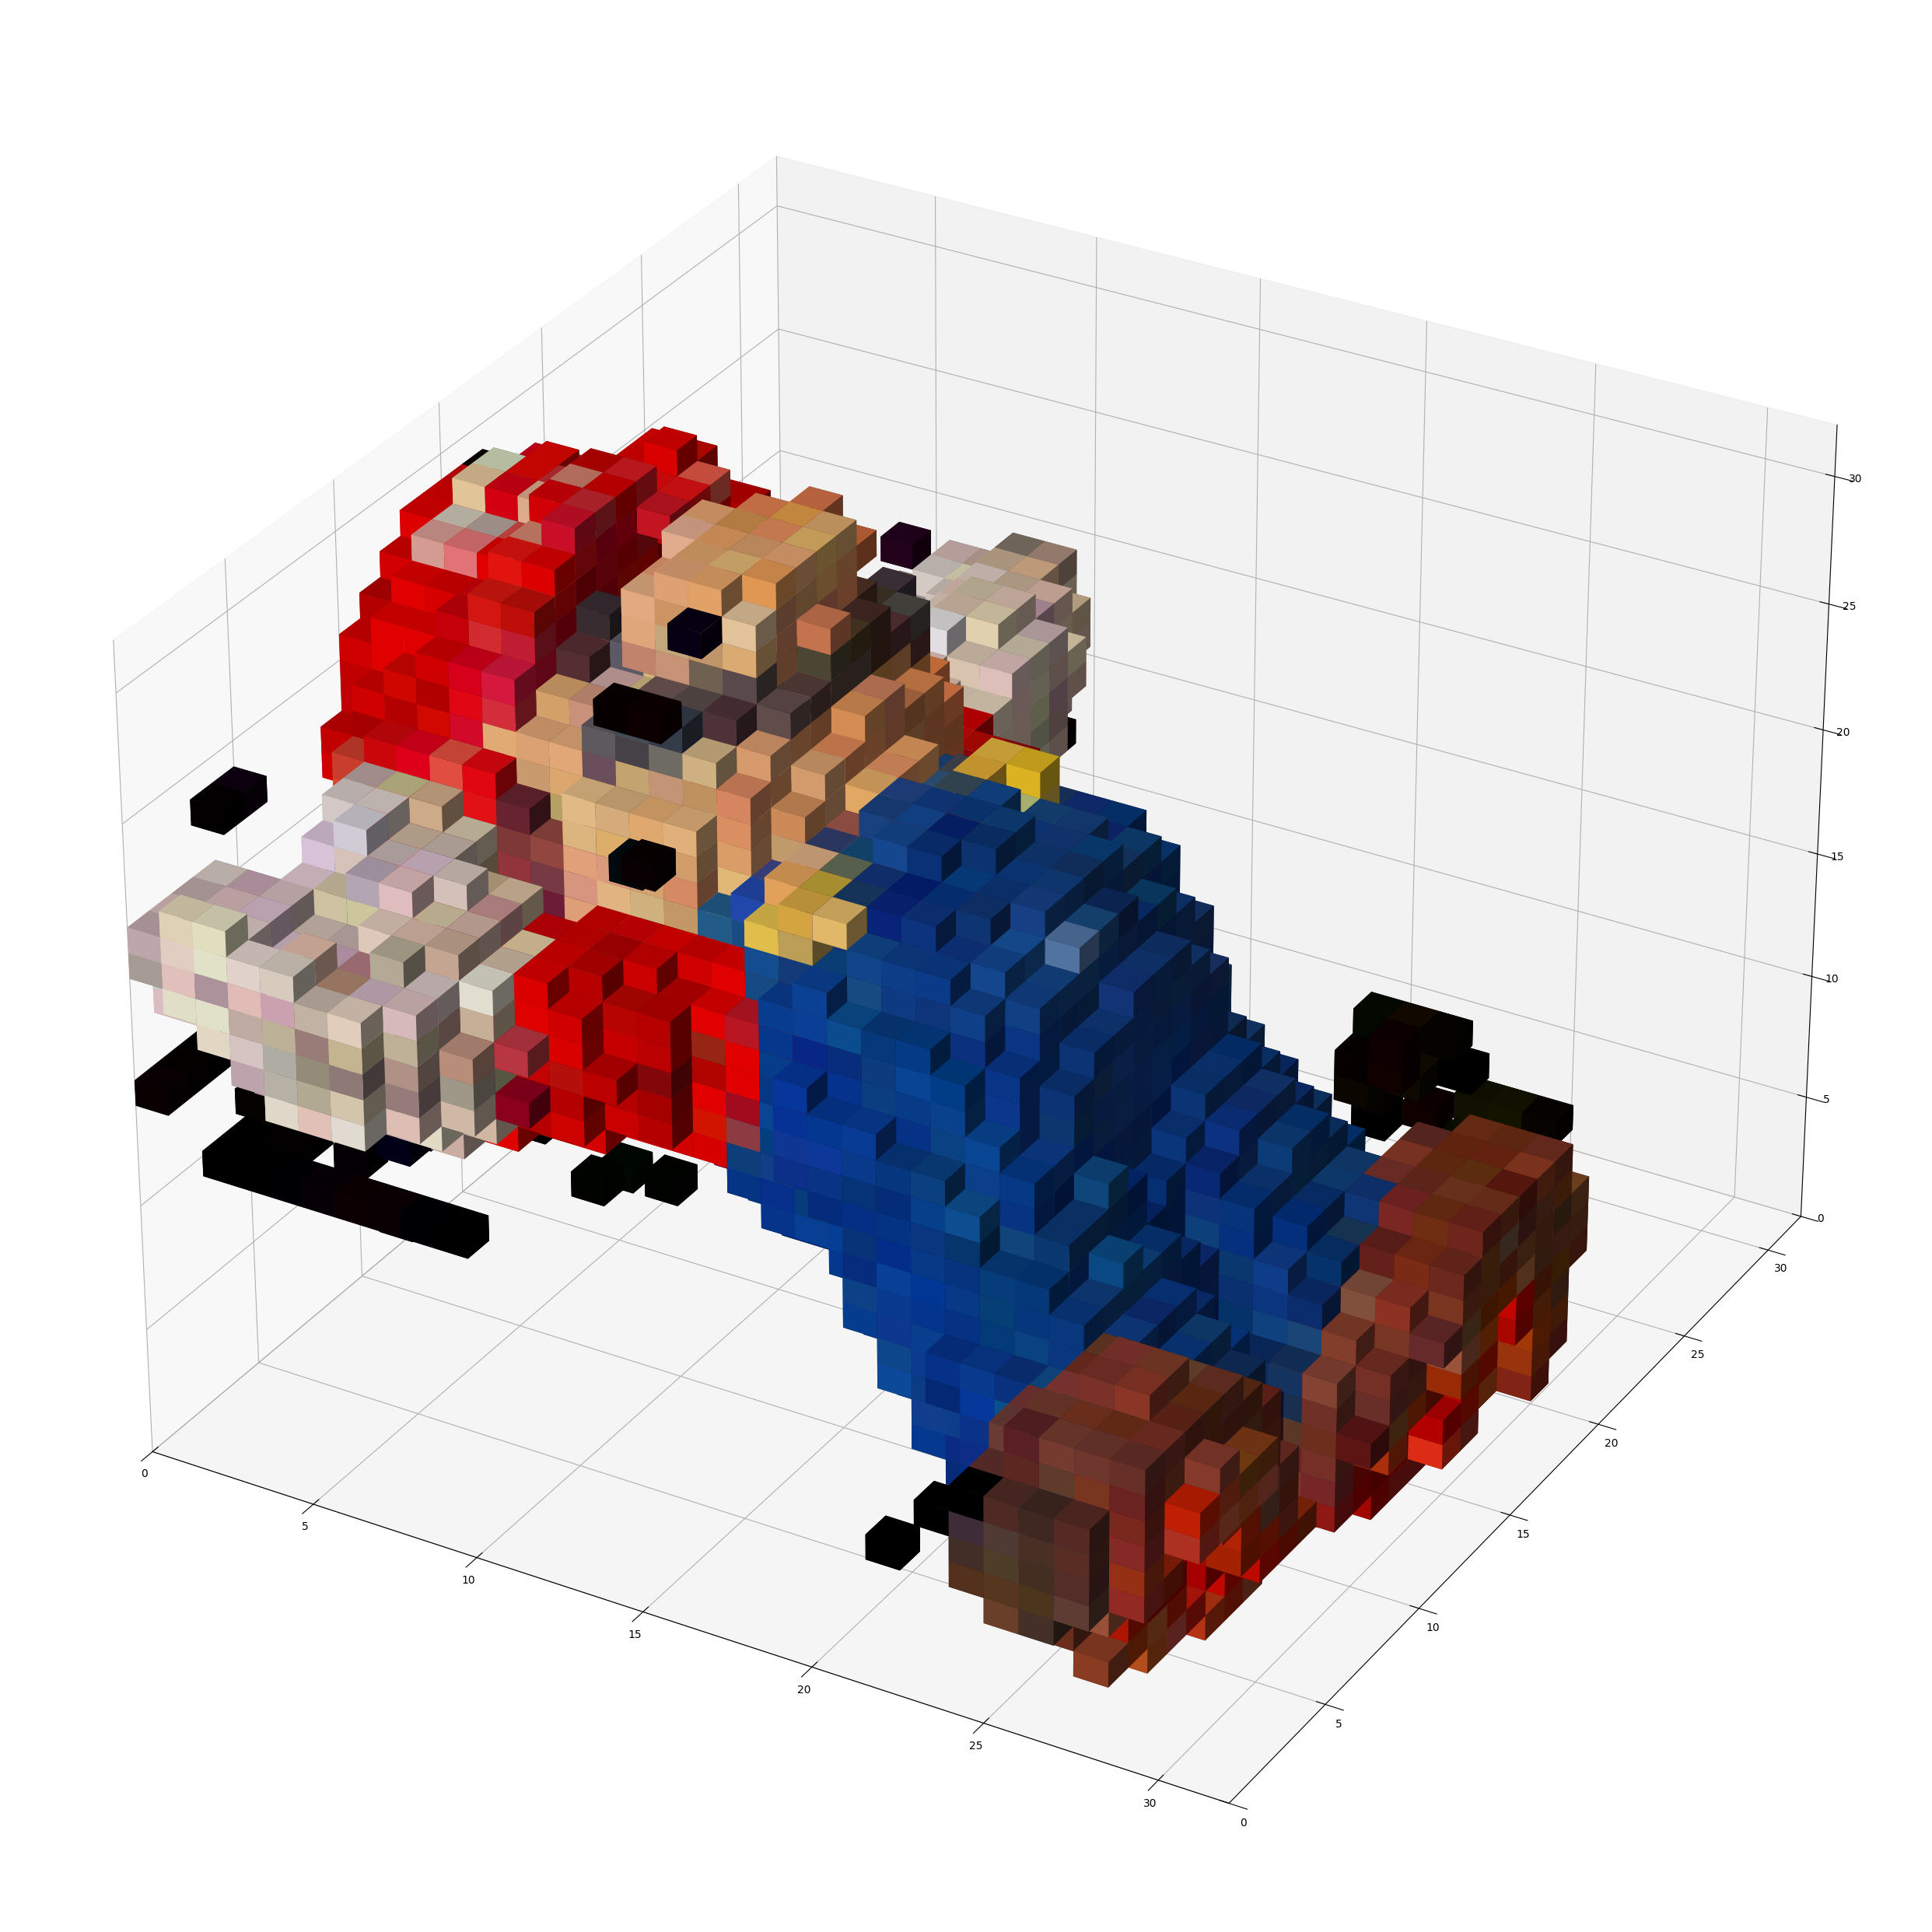

In [12]:
model.eval()
eval_iter = 32
torch.cuda.empty_cache()
with torch.no_grad():
    x = model.seed.unsqueeze(0)
    for i in tqdm(range(eval_iter)):
        x = model(x)
        # print(f"Iteration {i}: Loss{model.get_loss(x, rgba_voxels)[0].item()}")
    voxel_plot(torch.clamp(x[0, :4], min=0., max=1.))

### Video Generation

In [ ]:
# NOTE: ENSURE THE BELOW OUTPUT PATHS ARE CORRECT FOR YOU!

model.eval()
num_imgs = 200
# img_dir = "/home/henry/N3CTAR/data/test/imgs"
# video_dir = "/home/henry/N3CTAR/data/test"

img_dir = "/data/grickus/N3CTAR/test/imgs"
video_dir = "/data/grickus/N3CTAR/test"

with torch.no_grad():
    x = model.seed.unsqueeze(0)
    voxel_plot(torch.clamp(x[0, :4], min=0., max=1.), save_fig=True, img_dir=img_dir, iter=0)
    for i in tqdm(range(num_imgs)):
        x = model(x)
        voxel_plot(torch.clamp(x[0, :4], min=0., max=1.), save_fig=True, img_dir=img_dir, iter=i+1)


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
file_list = [os.path.join(img_dir, model_name, f"voxel_{i}.png") for i in range(num_imgs+1)]

clip = ImageSequenceClip(file_list, fps=12)
clip.write_videofile(os.path.join(video_dir, f"{model_name}.mp4"))